In [1]:
import glob
import os

import h5py
import numpy as np
import matplotlib.pyplot as pyplot
from PIL import Image
from pycocotools.coco import COCO
from torchvision.transforms import Resize
import matplotlib
import matplotlib.pyplot as plt
import skimage.io as io
import torch
from utils.data_loader import get_trn_loader, get_multi_site_trn_loader
from models.model import AttUNet

# trn_mean = np.asarray([0.46987239, 0.44626274, 0.40666163])
# trn_std = np.asarray([0.43082439, 0.43424141, 0.42904485])

# val_mean = np.asarray([0.46943393, 0.44602461, 0.40660645])
# val_std = np.asarray([0.43071977, 0.43432737, 0.42935181])

# coco = COCO('data/annotations/instances_train2017.json')

/home/somahansel/anaconda3/envs/mnist_test/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_dl = get_trn_loader(batch_size=500)
multi_train_dl = get_multi_site_trn_loader(batch_size=200, site_number=2)

In [5]:
for batch_tuple in train_dl:
    img, mask, img_id = batch_tuple
    print(img.shape)
    print(mask.shape)
    print(img_id.shape)
    break

torch.Size([500, 3, 64, 64])
torch.Size([500, 64, 64])
torch.Size([500])


In [6]:
model = AttUNet(num_classes=90)
out = model(img)
print(out.shape)

torch.Size([500, 90, 64, 64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-1.0625684
84.0


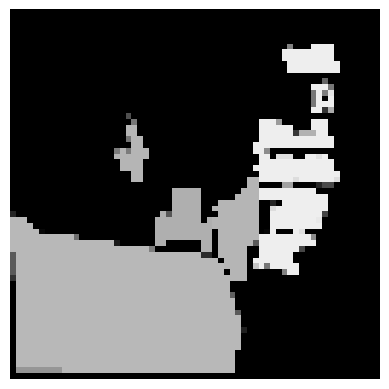

In [2]:
f = h5py.File('data/minicoco_trn.hdf5')
f2 = h5py.File('data/minicoco_val.hdf5')
ds = f2['data']
image = np.array(ds[2])
print(np.amin(image))
plt.imshow(image)
plt.axis('off')
plt.savefig('image.png')
ds2 = f2['mask']
mask = np.array(ds2[2])
print(np.amax(mask))
plt.imshow(mask / 90)
plt.axis('off')
plt.savefig('mask.png')
f.close()
f2.close()

In [ ]:
img = coco.loadImgs(139)
annIds = coco.getAnnIds(139)
anns = coco.loadAnns(annIds)
cat_ids = [ann['category_id'] for ann in anns]
# cats = [cat['name'] for cat in cat_ids]
cat_objs = coco.loadCats(cat_ids)
cats = [cat_obj['name'] for cat_obj in cat_objs]
print(cats)
mask = np.zeros((img[0]['height'], img[0]['width']))
for ann in anns:
    mask = np.maximum(coco.annToMask(ann) * ann['category_id'], mask)

plt.imshow(mask)
plt.axis('off')
plt.savefig('image.png')

In [9]:
val_path_list = glob.glob('data/images/val2017/*')
val_path_list.sort()
trn_path_list = glob.glob('data/images/train2017/*')
trn_path_list.sort()

trn_img_ids = [int(os.path.split(path)[-1][:12]) for path in trn_path_list]
# trn_ann_ids = [coco.getAnnIds(img_id) for img_id in trn_img_ids]
val_img_ids = [int(os.path.split(path)[-1][:12]) for path in val_path_list]
# val_ann_ids = [coco.getAnnIds(img_id) for img_id in val_img_ids]

In [ ]:
path = trn_path_list[0]
resize = Resize((64, 64))

image = Image.open(path)
image = resize(image)
np_data = np.asarray(image) / 255
np_data = np.divide(np_data - trn_mean, trn_std)
print(np.amax(np_data))
print(np.amin(np_data))
if len(np_data.shape) == 2:
    np_data = np.stack([np_data, np_data, np_data], axis=2)

img_id = trn_img_ids[0]
img = coco.loadImgs(img_id)
ann_ids = coco.getAnnIds(img_id)
anns = coco.loadAnns(ann_ids)
mask = np.zeros((1, 64, 64))
for ann in anns:
    ann_mask = coco.annToMask(ann) * ann['category_id']
    ann_mask = np.expand_dims(ann_mask, axis=0)
    ann_mask = torch.Tensor(ann_mask)
    ann_mask = np.asarray(resize(ann_mask)).astype(int)
    mask = np.maximum(ann_mask, mask)

mask = mask.transpose(1, 2, 0)
# plt.imshow(image)
# plt.axis('off')
# plt.savefig('image.png')
print(ann_ids)

In [ ]:
dataDir = './data'
dataType = 'val2017'

# Define the classes (out of the 81) which you want to see. Others will not be shown.
filterClasses = ['laptop']

# Fetch class IDs only corresponding to the filterClasses
catIds = coco.getCatIds(catNms=filterClasses) 
# Get all images containing the above Category IDs
imgIds = coco.getImgIds(catIds=catIds)
print("Number of images containing all the  classes:", len(imgIds))

img = coco.loadImgs(imgIds[0])[0]
I2 = io.imread('{}/images/{}/{}'.format(dataDir,dataType,img['file_name']))/255.0

plt.axis('off')
plt.imshow(I2)
plt.show()
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

In [ ]:
img = coco.loadImgs(724)
ann_id = coco.getAnnIds(imgIds=[724], iscrowd=None)
anns = coco.loadAnns(ann_id)
coco.showAnns(anns)

In [ ]:
for path in val_path_list[:10]:
    img_id = os.path.split(path)[-1][:12]
    print(img_id)

In [ ]:
t_psum = np.array([0.0, 0.0, 0.0], dtype=np.double)
t_psum_sq = np.array([0.0, 0.0, 0.0], dtype=np.double)
resize = Resize((64, 64))

for i, name in enumerate(trn_path_list):
    image = Image.open(name)
    image = resize(image)
    np_data = np.asarray(image)
    np_data = np_data / 255
    # print(np_data.shape)
    if len(np_data.shape) == 3:
        t_psum += np.sum(np_data, axis=(0, 1))
        t_psum_sq += np.sum(np.sqrt(np_data), axis=(0, 1))
    else:
        t_psum += np.sum(np_data)
        t_psum_sq += np.sum(np.sqrt(np_data))
    if i % 1000 == 0:
        print(i)
print(t_psum, t_psum_sq)

In [ ]:
count = 25000 * 64 * 64
t_mean = t_psum / count
t_std = t_psum_sq/count - t_mean**2
print(t_mean, t_std)

In [ ]:
v_psum = np.array([0.0, 0.0, 0.0], dtype=np.double)
v_psum_sq = np.array([0.0, 0.0, 0.0], dtype=np.double)
resize = Resize((64, 64))

for i, name in enumerate(val_path_list):
    image = Image.open(name)
    image = resize(image)
    np_data = np.asarray(image)
    np_data = np_data / 255
    if len(np_data.shape) == 3:
        v_psum += np.sum(np_data, axis=(0, 1))
        v_psum_sq += np.sum(np.sqrt(np_data), axis=(0, 1))
    else:
        v_psum += np.sum(np_data)
        v_psum_sq += np.sum(np.sqrt(np_data))
    if i % 1000 == 0:
        print(i)
print(v_psum, v_psum_sq)

In [ ]:
count = 5000 * 64 * 64
v_mean = v_psum / count
v_std = v_psum_sq/count - v_mean**2
print(v_mean, v_std)

In [ ]:
resize = Resize((64, 64))
for i, path in enumerate(val_path_list):
    image = Image.open(path)
    image = resize(image)
    np_data = np.asarray(image)
    if len(np_data.shape) == 2:
        np_data = np.stack([np_data, np_data, np_data], axis=2)
    np_data = np.divide(np_data-t_mean, t_std)
    print(np_data.shape)

    img_id = val_img_ids[i]
    img = coco.loadImgs(img_id)
    ann_ids = coco.getAnnIds(img_id)
    anns = coco.loadAnns(ann_ids)
    mask = np.zeros((img[0]['height'], img[0]['width']))
    for ann in anns:
        mask = np.maximum(coco.annToMask(ann) * ann['category_id'], mask)
    mask_tensor = torch.from_numpy(mask)
    print(mask_tensor.size())
    mask_resized = resize(mask_tensor.unsqueeze(0)).squeeze()
    mask = np.asarray(mask_tensor).astype(int)
    print(mask.shape)
    break

In [ ]:
max_w = 0
max_h = 0
min_w = 1000
min_h = 1000
min_ratio = 10
max_ratio = 0

for i, name in enumerate(val_path_list):
    image = Image.open(name)
    np_data = np.asarray(image)
    h, w = np_data.shape[:2]
    min_w = min(min_w, w)
    min_h = min(min_h, h)
    max_w = max(max_w, w)
    max_h = max(max_h, h)

    ratio_1 = h / w
    ratio_2 = w / h
    min_ratio = min(min_ratio, ratio_1, ratio_2)
    max_ratio = max(min_ratio, ratio_1, ratio_2)
    if i % 1000 == 0:
        print(i)

print('max_w:', max_w)
print('max_h:', max_h)
print('min_w:', min_w)
print('min_h:', min_h)
print('min_ratio:', min_ratio)
print('max_ratio:', max_ratio)

In [ ]:
t_max_w = 0
t_max_h = 0
t_min_w = 1000
t_min_h = 1000
t_min_ratio = 10
t_max_ratio = 0

for i, name in enumerate(trn_path_list):
    image = Image.open(name)
    np_data = np.asarray(image)
    h, w = np_data.shape[:2]
    t_min_w = min(t_min_w, w)
    t_min_h = min(t_min_h, h)
    t_max_w = max(t_max_w, w)
    t_max_h = max(t_max_h, h)

    ratio_1 = h / w
    ratio_2 = w / h
    t_min_ratio = min(t_min_ratio, ratio_1, ratio_2)
    t_max_ratio = max(t_min_ratio, ratio_1, ratio_2)
    if i % 1000 == 0:
        print(i)

print('t_max_w:', t_max_w)
print('t_max_h:', t_max_h)
print('t_min_w:', t_min_w)
print('t_min_h:', t_min_h)
print('t_min_ratio:', t_min_ratio)
print('t_max_ratio:', t_max_ratio)

In [ ]:
image = Image.open('data/images/val2017/000000000139.jpg')
np_data = np.asarray(image)
print(np_data.shape)
print(image.format)
print(image.size)
print(image.mode)
pyplot.imshow(image)
pyplot.show()